Files already downloaded and verified
Files already downloaded and verified


test_res:
[[52.  61.9 28.  17.3 56.  58.  48.9 53.8 59.1 42.2]
 [60.3 83.8 23.6 56.7 33.7 39.2 52.9 65.8 78.9 50.7]
 [50.9 58.2 29.2 60.8 68.2 37.6 53.9 76.6 78.4 68. ]
 [70.5 84.2 57.5 44.3 57.6 43.3 83.5 68.4 80.5 63. ]
 [70.  72.4 36.5 48.9 73.7 53.6 81.5 57.8 83.5 81.7]
 [70.7 87.9 46.3 63.7 43.9 56.6 83.3 62.3 82.4 75.7]
 [66.7 72.9 56.8 50.5 52.9 71.9 84.6 74.8 84.4 80.7]
 [75.5 81.2 51.4 53.5 66.2 70.2 74.6 76.4 79.6 83.2]
 [75.8 87.2 61.8 44.7 69.8 69.6 85.5 75.4 80.1 79.1]
 [72.6 86.7 52.8 66.9 68.5 53.6 74.8 82.3 79.  84.2]
 [75.8 86.6 65.6 53.6 74.1 67.3 81.6 83.6 86.  84.7]
 [78.1 84.7 66.3 58.5 75.6 65.9 79.7 77.9 86.  86.9]
 [77.8 83.7 68.  56.4 70.8 72.8 84.3 80.3 88.3 86.7]
 [81.9 88.8 66.5 59.5 71.8 64.6 85.7 79.6 86.7 87. ]
 [82.7 88.8 71.3 54.8 73.  61.8 86.2 81.2 84.6 83. ]
 [78.9 89.6 63.6 63.1 74.4 68.1 83.6 78.2 88.  82.4]
 [81.4 86.3 65.1 57.8 76.1 66.1 83.8 81.  86.  85.2]
 [78.2 90.1 69.1 61.9 74.1 64.2 82.4 79.5 88.1 85.9]
 [80.7 89.1 67.9 55.5 73.1 74.2 81.2

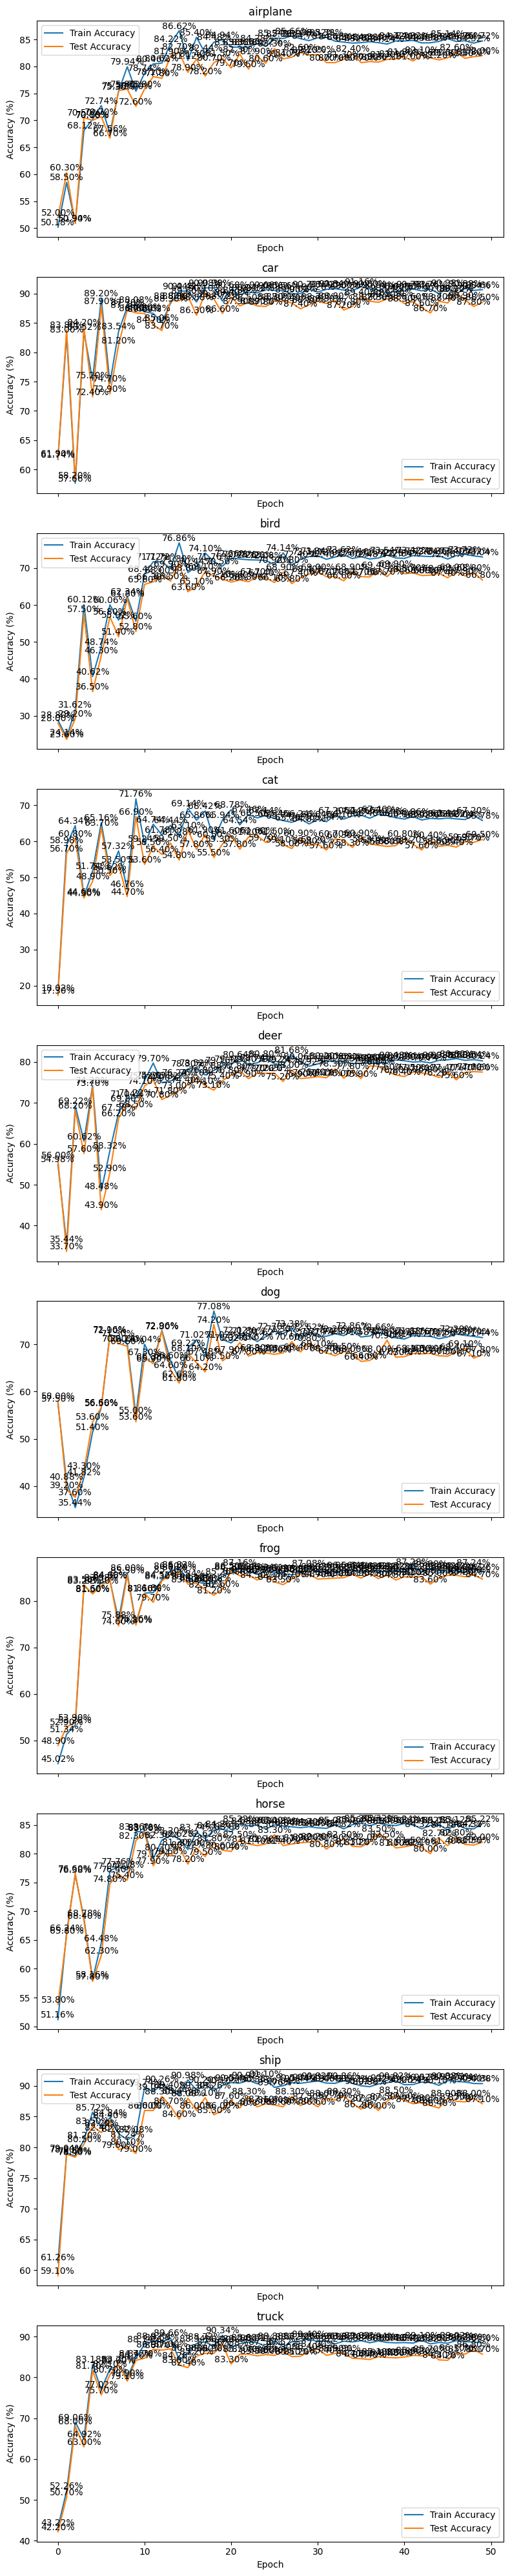

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np


# 将训练集和测试集的准确率曲线绘制出来
def draw(train_accuracy, test_accuracy, classes):
    # 获取 长度
    epochs = len(train_accuracy)
    x = range(epochs)
    num_classes = len(classes)

    fig, axes = plt.subplots(num_classes, 1, figsize=(8, num_classes*4), sharex=True)
    #写中文要加上其他代码
    for i, ax in enumerate(axes):
        if i < num_classes:
            ax.plot(x, train_accuracy[:, i], label='Train Accuracy')
            ax.plot(x, test_accuracy[:, i], label='Test Accuracy')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(classes[i])
            ax.legend()

            # 在每个节点上显示具体的数据
            for j, acc in enumerate(train_accuracy[:, i]):
                ax.annotate(f'{acc:.2f}%', xy=(j, acc), xytext=(j, acc), ha='center', va='bottom')
            for j, acc in enumerate(test_accuracy[:, i]):
                ax.annotate(f'{acc:.2f}%', xy=(j, acc), xytext=(j, acc), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# 对图像进行加载+预处理
def load_preprocess_cifar10(batch_size:int):
    # 归一化
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # 随机裁剪
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  
    # 读取数据,如果没有就下载
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 填充一圈0
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        # 10类
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 训练和评估模型
def train_and_evaluate_model(lr:float, momentum:float, weight_decay:float, batch_size:int, epoch:int):
    # 获得已经预处理好的数据
    trainloader, testloader = load_preprocess_cifar10(batch_size) 
    filename = 'model-epoch{}.pth'.format(epoch)
    
    net = Net()  # 创建自定义的模型对象
    # 定义loss函数
    criterion = nn.CrossEntropyLoss()  
    # 选择优化器
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) 
     # 定义学习率调度器 之前acc一直不变，上网搜加了这个就好了 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 


    num_classes = 10  
    # 初始化测试集和训练集准确率矩阵
    test_accuracies = np.zeros((epoch, num_classes))  
    train_accuracies = np.zeros((epoch, num_classes)) 

    for i in range(epoch):  # 迭代训练多个周期
        train_model(net, trainloader, criterion, optimizer)  # 训练模型
        # 计算每个类别的准确率
        test_accuracies[i] = evaluate_model_per_class(net, testloader, num_classes)  # 测试集准确率
        train_accuracies[i] = evaluate_model_per_class(net, trainloader, num_classes)  # 训练集准确率
        # 更新学习率
        scheduler.step()
    torch.save(net, filename)
    return test_accuracies, train_accuracies 

# 训练模型方法
def train_model(model, trainloader, criterion, optimizer):
    # 训练模型
    model.train()
    # 遍历训练集
    for _, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 评估模型方法(每个类别的准确率)
def evaluate_model_per_class(model, dataloader, num_classes):
    # 评估模型
    model.eval()
    # 初始化每个类别的正确数和总数
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            # 获得每个类别的预测值
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(num_classes):
                mask = labels == i
                total[i] += mask.sum().item()
                correct[i] += (predicted[mask] == labels[mask]).sum().item()
    # 计算每个类别的准确率
    accuracies = (100 * correct / total)
    return accuracies

if __name__ == '__main__':
    multiprocessing.freeze_support()
    classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    test_res, train_res = train_and_evaluate_model(lr=0.01,momentum=0.9,weight_decay=0.001,batch_size=64,epoch=50)
    print("test_res:")
    print(test_res)
    print("train_res:")
    print(train_res)
    draw(train_res, test_res, classes)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np


# 将训练集和测试集的准确率曲线绘制出来
def draw(train_accuracy, test_accuracy, classes):
    # 获取 长度
    epochs = len(train_accuracy)
    x = range(epochs)
    num_classes = len(classes)

    fig, axes = plt.subplots(num_classes, 1, figsize=(8, num_classes*4), sharex=True)
    #写中文要加上其他代码
    for i, ax in enumerate(axes):
        if i < num_classes:
            ax.plot(x, train_accuracy[:, i], label='Train Accuracy')
            ax.plot(x, test_accuracy[:, i], label='Test Accuracy')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(classes[i])
            ax.legend()

            # 在每个节点上显示具体的数据
            for j, acc in enumerate(train_accuracy[:, i]):
                ax.annotate(f'{acc:.2f}%', xy=(j, acc), xytext=(j, acc), ha='center', va='bottom')
            for j, acc in enumerate(test_accuracy[:, i]):
                ax.annotate(f'{acc:.2f}%', xy=(j, acc), xytext=(j, acc), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# 对图像进行加载+预处理
def load_preprocess_cifar10(batch_size:int):
    # 归一化
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # 随机裁剪
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  
    # 读取数据,如果没有就下载
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 填充一圈0
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        # 10类
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 训练和评估模型
def train_and_evaluate_model(lr:float, momentum:float, weight_decay:float, batch_size:int, epoch:int):
    # 获得已经预处理好的数据
    trainloader, testloader = load_preprocess_cifar10(batch_size) 
    filename = 'model-epoch{}.pth'.format(epoch)
    
    net = Net()  # 创建自定义的模型对象
    # 定义loss函数
    criterion = nn.CrossEntropyLoss()  
    # 选择优化器
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) 
     # 定义学习率调度器 之前acc一直不变，上网搜加了这个就好了 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 


    num_classes = 10  
    # 初始化测试集和训练集准确率矩阵
    test_accuracies = np.zeros((epoch, num_classes))  
    train_accuracies = np.zeros((epoch, num_classes)) 

    for i in range(epoch):  # 迭代训练多个周期
        train_model(net, trainloader, criterion, optimizer)  # 训练模型
        # 计算每个类别的准确率
        test_accuracies[i] = evaluate_model_per_class(net, testloader, num_classes)  # 测试集准确率
        train_accuracies[i] = evaluate_model_per_class(net, trainloader, num_classes)  # 训练集准确率
        # 更新学习率
        scheduler.step()
    torch.save(net, filename)
    return test_accuracies, train_accuracies 

# 训练模型方法
def train_model(model, trainloader, criterion, optimizer):
    # 训练模型
    model.train()
    # 遍历训练集
    for _, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 评估模型方法(每个类别的准确率)
def evaluate_model_per_class(model, dataloader, num_classes):
    # 评估模型
    model.eval()
    # 初始化每个类别的正确数和总数
    correct = np.zeros(num_classes)
    total = np.zeros(num_classes)

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            # 获得每个类别的预测值
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(num_classes):
                mask = labels == i
                total[i] += mask.sum().item()
                correct[i] += (predicted[mask] == labels[mask]).sum().item()
    # 计算每个类别的准确率
    accuracies = (100 * correct / total)
    return accuracies

if __name__ == '__main__':
    multiprocessing.freeze_support()
    classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    test_res, train_res = train_and_evaluate_model(lr=0.01,momentum=0.9,weight_decay=0.001,batch_size=64,epoch=100)
    print("test_res:")
    print(test_res)
    print("train_res:")
    print(train_res)
    draw(train_res, test_res, classes)

Files already downloaded and verified
Files already downloaded and verified


In [1]:
print(1)

1
